In [1]:
import matplotlib.image as matimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def mask_images(data, option='half'):
    valid_options = ('half', 'half random', '10 random', '20 random', '5 random')
    multipliers = {'half': 0.5, 'half random': 0.5, '10 random': 0.9, '20 random': 0.8, '5 random': 0.95}
    if option not in valid_options:
        raise ValueError(f"Option must be one of: {valid_options}")
    real_img = data[0]
    img_size = real_img.shape[2]
    masked_img, real_part = real_img.clone(), real_img.clone()
    # masking_equations = [2*117.0/255.0 - 1.0, 2*104.0/255.0 - 1.0, 2*123.0/255.0 - 1.0]
    # TESTING:
    masking_equations = [-1, -1, -1]
    if option == 'half':
        mask = np.zeros(real_img.shape[2:])
        mask[:int(img_size/2), :] = 1
        mask = mask.astype('bool') 
        for equation in masking_equations:
            masked_img[:, :, mask] = equation
            real_part[:, :, ~mask] = equation
    else:
        random_array = np.random.choice(2, int(img_size**2), p=[1 - multipliers[option], multipliers[option]])
        mask = random_array.reshape(real_img.shape[2:]).astype('bool')
        for equation in masking_equations:
            masked_img[:, :, mask] = equation
            real_part[:, :, ~mask] = equation
    return masked_img, real_part, mask

def resize_images(real_img):
    resize_images = real_img.clone()
    dim_size = int(resize_images.shape[2] / 4)
    resize_images = F.interpolate(resize_images, size=(dim_size, dim_size), mode='bilinear')
    return resize_images

In [3]:
from torchvision.utils import save_image
import torchvision.transforms as transforms
import torch
import torchvision.datasets as datasets
from torch.autograd import Variable
import torch.nn.functional as F

transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder(root='C:\\Users\\Korisnik\\github\\PMFST-Sensor-Augmentation\\source\\data\\celeba\\train', transform=transform )
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
torch.cuda.is_available()

True

In [14]:
data = next(iter(dataloader))
real_img = data[0]
masked_img, real_part, mask = mask_images(data, 'half random')
resized_img = resize_images(real_img)

c:\Users\Korisnik\github\PMFST-Sensor-Augmentation\.env\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


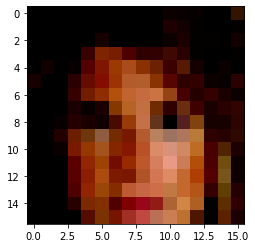

In [15]:
plt.imshow(resized_img[3].permute(1, 2, 0));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


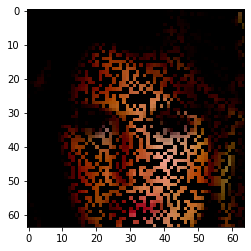

In [16]:
plt.imshow(masked_img[3].permute(1, 2, 0));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


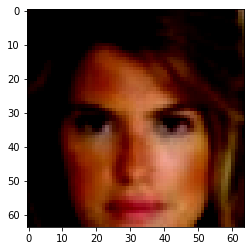

In [17]:
plt.imshow(real_img[3].permute(1, 2, 0));

In [11]:
print(real_img[1].max())
print(real_img[1].min())

tensor(0.9059)
tensor(-0.7882)


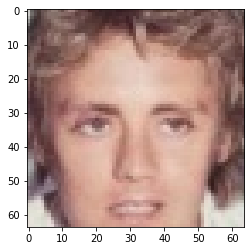

In [6]:
img = real_img[1].numpy()
# Transpose image so that last dim is number of channels and un-normalize
transposed_img = np.transpose(img, (1, 2, 0))
image = transposed_img * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
plt.imshow(image);

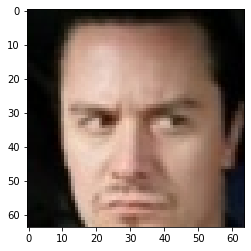

In [14]:
image = matimg.imread('mask_testing.jpg')
plt.imshow(image);

In [15]:
print(image.max())
print(image.min())

255
0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


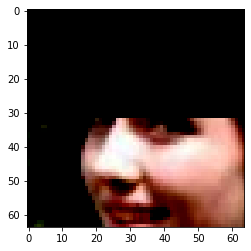

In [8]:
plt.imshow(masked_img[1].permute(1, 2, 0));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


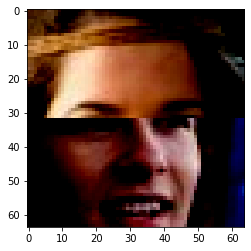

In [73]:
generated = real_img.clone()
input_image = masked_img.clone()

#concat_image = generated.clone()
generated[1, :, ~mask] = input_image[0, :, ~mask]
plt.imshow(generated[1].permute(1, 2, 0));

In [64]:
sample = torch.cat((real_img[:5].data, real_img[5:10].data, real_img[10:15].data), -2)
save_path = 'C:\\Users\\Korisnik\\github\\PMFST-Sensor-Augmentation\\thesis_images\\example.png'
save_image(sample, save_path, nrow=5, normalize=True)

In [7]:
sample = torch.cat((masked_img[:5].data, real_img[:5].data), -2)
save_path = 'C:\\Users\\Korisnik\\github\\PMFST-Sensor-Augmentation\\thesis_images\\5_random.png'
save_image(sample, save_path, nrow=5, normalize=True)

In [65]:
patch_h, patch_w = int(64 / 2 ** 3), int(64 / 2 ** 3)
patch = (1, patch_h, patch_w)

valid = Variable(torch.FloatTensor(16, *patch).fill_(1.0), requires_grad=False)
fake = Variable(torch.FloatTensor(16, *patch).fill_(0.0), requires_grad=False)

In [66]:
label = torch.full((16, 1, 8, 8), 1, dtype=torch.float)

In [67]:
def apply_random_mask(img, mask_size):
    """Randomly masks image"""
    y1, x1 = np.random.randint(0, img.shape[0] - mask_size, 2)
    y2, x2 = y1 + mask_size, x1 + mask_size
    masked_part = img[y1:y2, x1:x2, :]
    masked_img = img.copy()
    masked_img[y1:y2, x1:x2, :] = 1
    return masked_img, masked_part

In [68]:
masked_image, masked_part = apply_random_mask(image, 16)

NameError: name 'image' is not defined

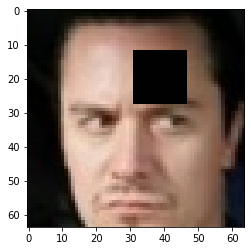

In [ ]:
plt.imshow(masked_image);

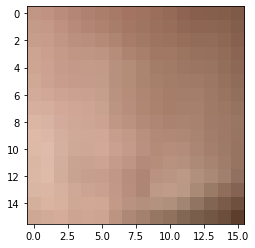

In [ ]:
plt.imshow(masked_part);

In [ ]:
one_image = real_part[1]
squeezed = one_image[:, mask]

In [ ]:
def apply_random_mask(img):
    idx = np.random.randint(0, 64 - 8, (img.shape[0], 2))
    masked_img = img.copy()
    for y1, x1 in idx:
        y2, x2 = y1 + 8, x1 + 8
        masked_img[y1:y2, x1:x2, :] = -1

    return masked_img

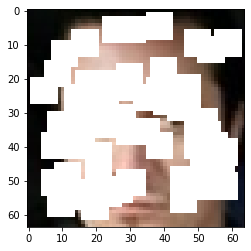

In [ ]:
testing_img = apply_random_mask(image)
plt.imshow(testing_img);

In [4]:
cnn_loss = pd.read_csv('losses_cnn_20.csv', index_col=False)
ccgan_loss = pd.read_csv('losses_ccgan_half.csv', index_col=False)
aegan_loss = pd.read_csv('losses_aegan_half.csv', index_col=False)

In [17]:
aegan_loss

,Unnamed: 0,Discriminator,Generator
0,0,0.423669,0.369199
1,1,2.699718,0.187362
2,2,1.023042,0.163317
3,3,0.975283,0.148538
4,4,0.627793,0.164320
...,...,...,...
395,395,0.009754,0.054961
396,396,0.028070,0.059904
397,397,0.021658,0.055390
398,398,0.261436,0.058914


Text(0.5, 1.0, 'AEGAN i CCGAN')

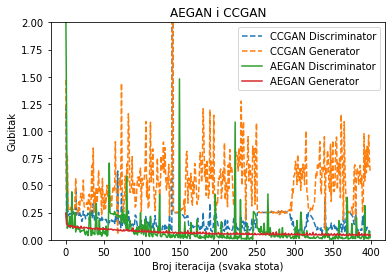

In [6]:
plt.plot(ccgan_loss.Discriminator, label='CCGAN Discriminator', linestyle='--')
plt.plot(ccgan_loss.Generator, label='CCGAN Generator', linestyle='--')
plt.plot(aegan_loss.Discriminator, label='AEGAN Discriminator')
plt.plot(aegan_loss.Generator, label='AEGAN Generator')
plt.ylim(0.0, 2.0)
plt.legend()
plt.xlabel('Broj iteracija (svaka stota)')
plt.ylabel('Gubitak')
plt.title('AEGAN i CCGAN')

Text(0.5, 1.0, 'CNN')

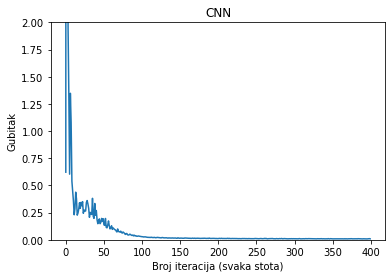

In [4]:
plt.plot(cnn_loss.MSELoss)
plt.ylim(0.0, 2.0)
plt.xlabel('Broj iteracija (svaka stota)')
plt.ylabel('Gubitak')
plt.title('CNN')